# lesson12

In [1]:

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

###欧式期权###
#初始参数
S0 = 100.  #标的资产初始价格
r = 0.05   #无风险利率
sigma = 0.25   #标的资产波动率
T = 1.0   #到期日
I = 50000  #模拟数量

#二项分布模拟
def bin_sn(T, I, p = None):
    ''' Function to generate random numbers for simulation.
    
    Parameters
    ==========
    T : int
        周期数
    I : int
        模拟数量
    p : float
        风险中性概率

    '''
    sn = npr.binomial(T,p,size=I)
    return sn

#二叉树模型下的看涨期权估值   
def CRRF(K,u,d,T):
    ''' 
    基于二叉树模型使用蒙特卡洛方法模拟计算欧式看涨期权的价格
    
    Parameters
    ==========
    K : float
        行权价
    u : float
        股票上涨比率
    d : float
        股票下降比率
    
    Returns
    =======
    C0 : float
        对欧式看涨期权的估值
    '''
    sn = bin_sn(T, I, p=(r-d)/(u-d)) 
    #随机生成标的资产的到期价格
    ST = S0 *((1+u)**sn)*((1+d)**(T-sn))
    # 计算
    hT = np.maximum(ST-K, 0)
    # calculate MCS estimator
    C0 = np.exp(-r * T) * 1 / I * np.sum(hT)
    return C0    

CRRF(K=105,u=0.2,d=-0.2,T=T) 

8.937180934954009

In [6]:
#定义正态分布随机数生成函数
def gen_sn(M, I, anti_paths=True, mo_match=True):
    ''' Function to generate random numbers for simulation.
    
    Parameters
    ==========
    M : int
        周期数
    I : int
        模拟数量
    anti_paths: boolean
        是否使用对偶变量（若是，则只提取I的一半数目的随机数，另一半取其相反数获得）
    mo_math : boolean
        是否使用距匹配方法（若是，使用标准化方法校正生成的随机数）
    '''
    if anti_paths is True:
        sn = npr.standard_normal((M + 1, I // 2))
        sn = np.concatenate((sn, -sn), axis=1)
    else:
        sn = npr.standard_normal((M + 1, I))
    if mo_match is True:
        sn = (sn - sn.mean()) / sn.std()
    return sn
    
#连续时间模型下的欧式看涨期权估值函数    
def gbm_mcs_stat(K):
    ''' 
    连续时间模型下使用蒙特卡洛方法模拟计算欧式看涨期权的价格
    
    Parameters
    ==========
    K : float
        行权价
    
    Returns
    =======
    C0 : float
        对欧式看涨期权的估值
    '''
    sn = gen_sn(1, I) #生成随机序列
    
    ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T 
                 + sigma * np.sqrt(T) * sn[1])
    # 计算
    hT = np.maximum(ST - K, 0)
    # calculate MCS estimator
    C0 = np.exp(-r * T) * 1 / I * np.sum(hT)
    return C0

gbm_mcs_stat(K=105.)

10.015993184283078

In [7]:
#欧式期权估值
M = 50
def gbm_mcs_dyna(K, option='call'):
    ''' Valuation of European options in Black-Scholes-Merton
    by Monte Carlo simulation (of index level paths)
    
    Parameters
    ==========
    K : float
        行权价
    option : string
        期权类型(看涨=call,看跌=put)
    
    Returns
    =======
    C0 : float
        欧式期权的现值估计值
    '''
    dt = T / M #时间段计算
    # 模拟
    S = np.zeros((M + 1, I))
    S[0] = S0
    sn = gen_sn(M, I)
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt 
                + sigma * np.sqrt(dt) * sn[t])
    # 计算收益序列
    if option == 'call':
        hT = np.maximum(S[-1] - K, 0)
    else:
        hT = np.maximum(K - S[-1], 0)
    # 计算期权估计值
    C0 = np.exp(-r * T) * 1 / I * np.sum(hT)
    return C0
    
gbm_mcs_dyna(K=110., option='call')

7.834579582145581

In [8]:
gbm_mcs_dyna(K=110., option='put')

12.618577721908236

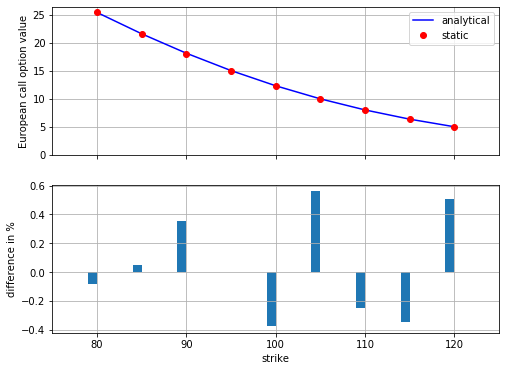

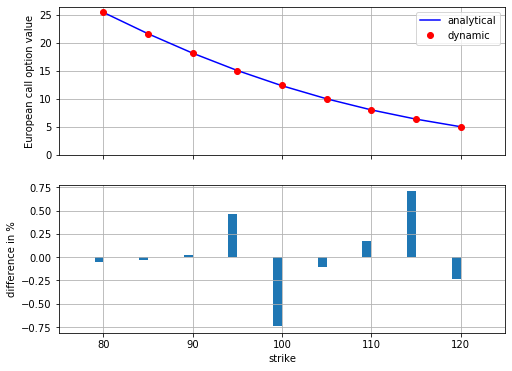

In [9]:
##与BSM估值公式比较

#看涨期权估值
def bsm_call_value(S0, K, T, r, sigma):
    ''' Valuation of European call option in BSM model.
    Analytical formula.
    
    Parameters
    ==========
    S0 : float
        标的资产初始价格
    K : float
        行权价
    T : float
        到期日(以年为单位)
    r : float
        无风险利率
    sigma : float
        扩散项中的波动因子
    
    Returns
    =======
    value : float
        欧式看涨期权现值
    '''
    from math import log, sqrt, exp
    from scipy import stats

    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0)
            - K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
      # stats.norm.cdf --> cumulative distribution function
      #                    for normal distribution
    return value

#价格对比
stat_res = []
dyna_res = []
anal_res = []
k_list = np.arange(80., 120.1, 5.)
np.random.seed(200000)
for K in k_list:
    stat_res.append(gbm_mcs_stat(K)) 
    dyna_res.append(gbm_mcs_dyna(K))
    anal_res.append(bsm_call_value(S0, K, T, r, sigma))
stat_res = np.array(stat_res)
dyna_res = np.array(dyna_res)
anal_res = np.array(anal_res)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax1.plot(k_list, anal_res, 'b', label='analytical')
ax1.plot(k_list, stat_res, 'ro', label='static')
ax1.set_ylabel('European call option value')
ax1.grid(True)
ax1.legend(loc=0)
ax1.set_ylim(ymin=0)
wi = 1.0
ax2.bar(k_list - wi / 2, (anal_res - stat_res) / anal_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('difference in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax1.plot(k_list, anal_res, 'b', label='analytical')
ax1.plot(k_list, dyna_res, 'ro', label='dynamic')
ax1.set_ylabel('European call option value')
ax1.grid(True)
ax1.legend(loc=0)
ax1.set_ylim(ymin=0)
wi = 1.0
ax2.bar(k_list - wi / 2, (anal_res - dyna_res) / anal_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('difference in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)

In [10]:
###美式期权###
def gbm_mcs_amer(K, option='call'):
    ''' Valuation of American option in Black-Scholes-Merton
    by Monte Carlo simulation by LSM algorithm
    
    Parameters
    ==========
    K : float
        行权价
    option : string
        期权类型 ('call', 'put')
    
    Returns
    =======
    C0 : float
        美式期权现值的估计
    '''
    dt = T / M
    df = np.exp(-r * dt)
    # 模拟价格路径
    S = np.zeros((M + 1, I))
    S[0] = S0
    sn = gen_sn(M, I)
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt 
                + sigma * np.sqrt(dt) * sn[t])
    # 回报计算
    if option == 'call':
        h = np.maximum(S - K, 0)
    else:
        h = np.maximum(K - S, 0)
    # LSM算法
    V = np.copy(h)
    for t in range(M - 1, 0, -1):
        reg = np.polyfit(S[t], V[t + 1] * df, 7)
        C = np.polyval(reg, S[t])
        V[t] = np.where(C > h[t], V[t + 1] * df, h[t])
    # MCS估计值
    C0 = df * 1 / I * np.sum(V[1])
    return C0
    
gbm_mcs_amer(110., option='call')   

7.778933279449316

In [11]:
gbm_mcs_amer(110., option='put')


13.614023206242445

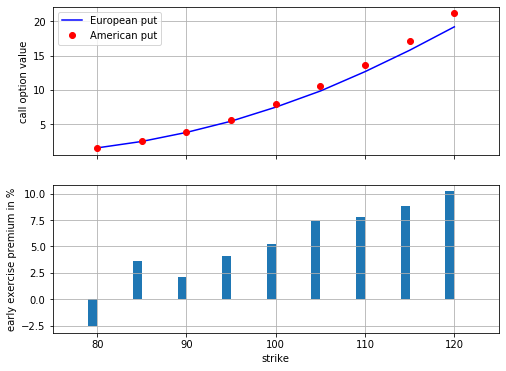

In [12]:
#比较欧式期权与美式期权
euro_res = []
amer_res = []
k_list = np.arange(80., 120.1, 5.)
for K in k_list:
    euro_res.append(gbm_mcs_dyna(K, 'put'))
    amer_res.append(gbm_mcs_amer(K, 'put'))
euro_res = np.array(euro_res)
amer_res = np.array(amer_res)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax1.plot(k_list, euro_res, 'b', label='European put')
ax1.plot(k_list, amer_res, 'ro', label='American put')
ax1.set_ylabel('call option value')
ax1.grid(True)
ax1.legend(loc=0)
wi = 1.0
ax2.bar(k_list - wi / 2, (amer_res - euro_res) / euro_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('early exercise premium in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)